In [1]:
import os
from scipy.special import logsumexp

# change to the root folder
os.chdir("..")

from tests.test_zestimation import *

In [2]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Quasar Redshift Normalization Improvement

Instead of just dividing the median of the flux (at a certain wavelength range), we marginalize over the distribution of the flux (at a certain wavelength range).

In [3]:
# read the first spectrum from SDSS DR12
nspec = 59
# path to the learned GP model
learned_file = "data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat"

# filenames is an array for a list of spectra, and we take one of them here
filename = filenames[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

# Initialize the model parameters
params = ZParameters()
z_qso_samples = ZSamples(params)

# load the model
z_qso_gp = ZGPMAT(
    params,
    z_qso_samples,
    learned_file=learned_file,
)

[Info] retrieving https://data.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/spectra/4296/spec-4296-55499-0386.fits ... Done.


In [4]:
# 10,000 test redshifts, from 2 ~ 5
# For high-z spectra, sometimes they go above 5.
# You can set the maximum to be 7.
test_redshifts = np.linspace(2, 5, 10000)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred = test_redshifts[idx]
print(z_pred)

2.3954395439543954


In [5]:
# redo the inference just around the catalog value,
# but we also want to include the z_pred in the sampling range
dz = np.abs(z_pred - z_qsos[nspec])

test_redshifts = np.linspace(z_qsos[nspec] - 2*dz, z_qsos[nspec] + 2*dz, 100)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred_m = test_redshifts[idx]
print(z_pred_m)

2.3954858316922296


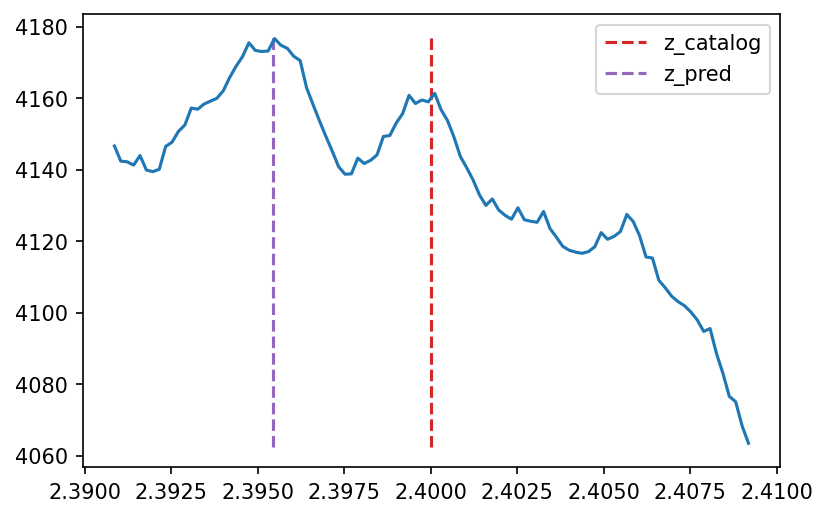

In [6]:
plt.plot(test_redshifts, sample_log_likelihoods)
plt.vlines(z_qsos[nspec], min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C3", label="z_catalog")
plt.vlines(z_pred, min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C4", label="z_pred")
plt.legend()

In [7]:
# marginalize over the normalization factor
test_redshifts = np.linspace(z_qsos[nspec] - 2*dz, z_qsos[nspec] + 2*dz, 100)

sample_log_likelihoods_m = []
list_sample_norm_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # manually normalize the flux
    ind = (z_qso_gp.x >= z_qso_gp.params.normalization_min_lambda) & (
           z_qso_gp.x <= z_qso_gp.params.normalization_max_lambda)
    # sampling normalization range
    min_norm, median_norm, max_norm = np.quantile(z_qso_gp.y[ind], [0.05, 0.5, 0.95])
    y_old = z_qso_gp.y
    v_old = z_qso_gp.v
    
    sample_norm_log_likelihoods = []

    for norm in z_qso_gp.y[ind]:
#     for norm in np.linspace(min_norm, max_norm, 100):
        z_qso_gp.y = y_old / norm
        z_qso_gp.v = v_old / norm**2

        sample_norm_log_likelihoods.append(z_qso_gp.log_model_evidence() ) #+ np.log(prior))

    # [get the likelihood value]
    sample_log_likelihoods_m.append(logsumexp(sample_norm_log_likelihoods))
    
    list_sample_norm_log_likelihoods.append(sample_norm_log_likelihoods)

In [8]:
# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods_m)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred_norm = test_redshifts[idx]
print("zCatalog, zPred, zPredNorm", z_qsos[nspec], z_pred, z_pred_norm)

zCatalog, zPred, zPredNorm 2.40002203 2.3954395439543954 2.3960412845462424


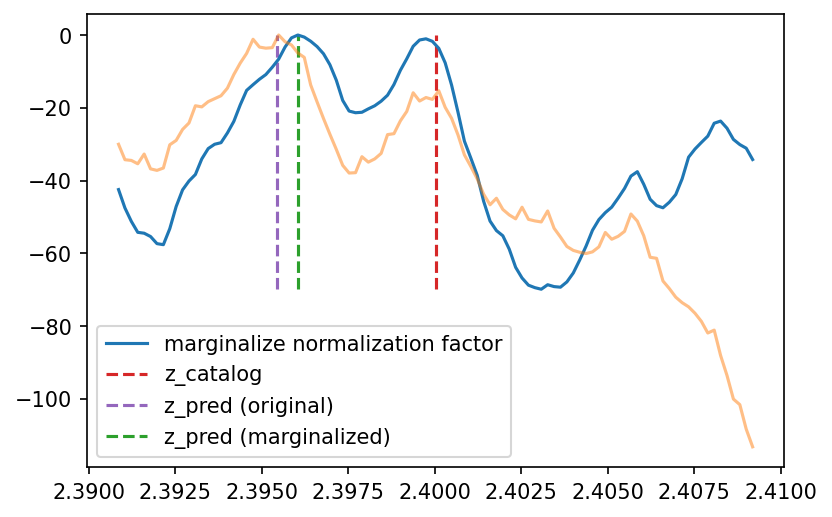

In [9]:
plt.plot(test_redshifts, sample_log_likelihoods_m - np.max(sample_log_likelihoods_m), label="marginalize normalization factor")
plt.plot(test_redshifts, sample_log_likelihoods - np.max(sample_log_likelihoods), alpha=0.5, color="C1")
plt.vlines(
    z_qsos[nspec],
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C3",
    label="z_catalog"
)
plt.vlines(
    z_pred,
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C4",
    label="z_pred (original)"
)
plt.vlines(
    z_pred_norm,
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C2",
    label="z_pred (marginalized)"
)

plt.legend()

In [10]:
print("(zCatalog - zPred) / zCatalog = {:.3g}".format((z_qsos[nspec] - z_pred) / z_qsos[nspec]))
print("(zCatalog - zPredNorm) / zCatalog = {:.3g}".format((z_qsos[nspec] - z_pred_norm) / z_qsos[nspec]))

(zCatalog - zPred) / zCatalog = 0.00191
(zCatalog - zPredNorm) / zCatalog = 0.00166
